online keras course : https://www.tensorflow.org/tutorials/images/classification

In [1]:
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
running_on_kaggle = False

if running_on_kaggle:
    all_images_data_dir = '/kaggle/input/food41/images/'
else:
    all_images_data_dir = './dataset/food/images/'
    !pip install --quiet -r requirements.txt
    !python download_data.py

food41.zip: Skipping, found more recently modified local copy (use --force to force download)
Found /food folder already extracted


In [3]:
classes_to_keep = ['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']

if running_on_kaggle:
    for elt in classes_to_keep:
        try:
            shutil.copytree(all_images_data_dir + elt,'/kaggle/temp/images_kept/' + elt)
        except:
            print("class ", elt, "already exists !")
    data_dir = '/kaggle/temp/images_kept/'
else:
    for elt in classes_to_keep:
        shutil.copytree(all_images_data_dir + elt,'./dataset/food/images_kept/' + elt, dirs_exist_ok=True)
    data_dir = './dataset/food/images_kept/'

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.1,
    subset="training",
    image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.1,
    subset="validation",
    image_size=(img_height, img_width))

Found 4000 files belonging to 4 classes.
Using 3600 files for training.
Found 4000 files belonging to 4 classes.
Using 400 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']


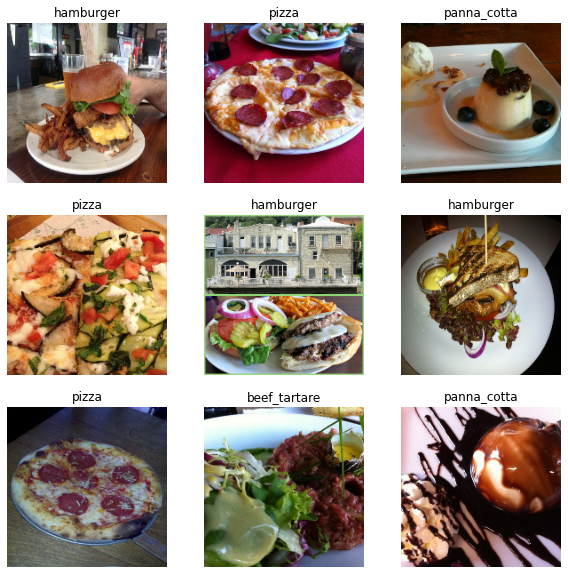

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

In [14]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
 78/113 [===================>..........] - ETA: 34s - loss: 1.3996 - accuracy: 0.2835

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()